# Consumptions and Energy Generation analysis

This notebook describes all data analysis on resource consumption and power generation.

Loading the necessary packages:

In [1]:
# load all necessary imports
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date, timedelta
import numpy as np
from scipy.signal import butter, filtfilt

Set the corresponding variables for the data analysis:
- files for actual year data set and historical data
- year of analysis

In [2]:
actuals_file_name:str = "./../bin/" + "counters.csv"
hist_file_name:str = "./../bin/" + "consumes.csv"
results_folder_path:str = "./../bin/results/"
ANALYSIS_YEAR:int = date.today().year

Load the data frames from the csv files:

In [3]:
# get the start and end dates of the year
start_date = date(ANALYSIS_YEAR, 1, 1)
end_date = date(ANALYSIS_YEAR, 12, 1)
# load the data frame
all_actuals_df = pd.read_csv(actuals_file_name, index_col='Date', parse_dates=['Date'])
# filter for year
actuals_df = all_actuals_df[start_date:end_date]


Filter function

In [4]:
# Function to apply a low-pass filter
def low_pass_filter(data, cutoff_freq, sampling_freq, order=4):
    nyquist = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Pad the data before applying the filter
    padlen = 15
    data_padded = np.pad(data, (padlen, padlen), mode='edge')
    y_filtered = filtfilt(b, a, data_padded)

    # Trim the padded data
    y_filtered = y_filtered[padlen:padlen+len(data)]

    return y_filtered

Calculate Statistics per Year, start with the consumptions

In [5]:
stats_dict = {}

# Columns in the data frame
# Gas	Water	Power In	Power Out	Power Gen	Power PV used	Power used	Power Car Stephan	Power Car Heike	Power Car Wink	
#for col in actuals_df.columns:
#    print(col + "   ", end="")
# general consumption statistics
consumtion = round(actuals_df["Gas"][-1] - actuals_df["Gas"][0], 2)
stats_dict["Gasverbrauch (kWh)"] = consumtion
consumtion = round(actuals_df["Water"][-1] - actuals_df["Water"][0], 2)
stats_dict["Wasserverbrauch (qm)"] = consumtion
consumtion = round(actuals_df["Power In"][-1] - actuals_df["Power In"][0], 2)
stats_dict["Strombezug (kWh)"] = consumtion

Calculate the vehicle power usage statisticis

In [6]:
# vehicle energy consumption
consumtion = round(actuals_df["Power Car Stephan"][-1] - actuals_df["Power Car Stephan"][0], 2)
stats_dict["Strom für V60 (kWh)"] = consumtion
consumtion = round(actuals_df["Power Car Heike"][-1] - actuals_df["Power Car Heike"][0], 2)
stats_dict["Strom für XC40 (kWh)"] = consumtion
consumtion = stats_dict["Strom für V60 (kWh)"] 
consumtion = consumtion + stats_dict["Strom für XC40 (kWh)"] 
consumtion = round(consumtion + (actuals_df["Power Car Wink"][-1] - actuals_df["Power Car Wink"][0]), 2)
stats_dict["Strom für alle Autos (kWh)"] = consumtion

Calculate all statistics related to energy production

In [7]:
# energy production statistics
stats_dict["Tagessummen Stromproduktion (kWh)"] = round(actuals_df["Power Gen"].sum(), 2)
stats_dict["Tagessummen Eigenverbrauch (kWh)"] = round(actuals_df["Power PV used"].sum(), 2)
stats_dict["Tagessummen Stromverbrauch (kWh)"] = round(actuals_df["Power used"].sum(), 2)
stats_dict["Max Stromproduktion per Tag (kWh)"] = round(actuals_df["Power Gen"].max(), 2)
stats_dict["Max Stromproduktion Tag"] = actuals_df["Power Gen"].idxmax()
stats_dict
# get a subset of the data frame where the power generation is not 0.0
actuals_with_pwr_df = actuals_df[actuals_df["Power PV used"] > 0.0]
stats_dict["Mittelwert Stromproduktion (kWh)"] = round(actuals_with_pwr_df["Power Gen"].mean(), 2)
stats_dict["Mittelwert Eigenverbrauch (kWh)"] = round(actuals_with_pwr_df["Power PV used"].mean(), 2)
stats_dict["Mittelwert Tagesverbrauch (kWh)"] = round(actuals_with_pwr_df["Power used"].mean(), 2)
stats_dict["Aktueller Verbrauch pro Jahr (kWh)"] = round(stats_dict["Tagessummen Eigenverbrauch (kWh)"] + stats_dict["Strombezug (kWh)"], 2)
stats_dict["Geschätzter Verbrauch pro Jahr (kWh)"] = round(actuals_with_pwr_df["Power used"].mean() * 356, 2)
stats_dict["Geschätzter Autarkiegrad (%)"] = round(stats_dict["Mittelwert Eigenverbrauch (kWh)"] /
                                                   stats_dict["Mittelwert Tagesverbrauch (kWh)"] * 100.0, 2)
stats_dict["Stromanteil Autos (%)"] = round(stats_dict["Strom für alle Autos (kWh)"] /
                                            stats_dict["Strombezug (kWh)"] * 100.0, 2)


Calculate Autarkie analysis

In [8]:
# get the autakie value of each day and add it to the actuals data frame
autarks_s = actuals_with_pwr_df["Power PV used"] / actuals_with_pwr_df["Power used"] * 100.0
autarks_s = autarks_s.rename('Autark')
# normalize it to 100%, everything about 100% is not interesting as this is feed back
autarks_s = autarks_s.where(autarks_s <= 100, 100)
# add the new autarkie data set to the actuals data frame
actuals_with_pwr_df = pd.concat([actuals_with_pwr_df, autarks_s], axis=1)

stats_dict["Realer Autarkiegrad pro Tag(%)"] = round(actuals_with_pwr_df["Autark"].mean(), 2)

# generate a low passed filtered data column from autarkie
# set the sampling frequency and cutoff frequency for the low-pass filter
sampling_frequency = 1.0  # Adjust based on your data
cutoff_frequency = 0.05 # Adjust based on your requirements
# apply the low-pass filter to the 'y' column
actuals_with_pwr_df['Autark_filtered'] = low_pass_filter(actuals_with_pwr_df["Autark"], cutoff_frequency, sampling_frequency)


Print the statistics and store it

In [9]:
# display and store the statistics
for keys, values in stats_dict.items():
    print(f"{keys}:    {values}")

# Print the data 
actual_stats_s = series_data = pd.Series(stats_dict)
result_file = results_folder_path + str(ANALYSIS_YEAR) + "_stats_csv"
actual_stats_s.to_csv(result_file, header=False)

Gasverbrauch (kWh):    310.0
Wasserverbrauch (qm):    54.0
Strombezug (kWh):    2474.0
Strom für V60 (kWh):    191.0
Strom für XC40 (kWh):    236.0
Strom für alle Autos (kWh):    520.0
Tagessummen Stromproduktion (kWh):    3432.08
Tagessummen Eigenverbrauch (kWh):    1578.05
Tagessummen Stromverbrauch (kWh):    2123.54
Max Stromproduktion per Tag (kWh):    53.0
Max Stromproduktion Tag:    2023-09-05 00:00:00
Mittelwert Stromproduktion (kWh):    22.14
Mittelwert Eigenverbrauch (kWh):    10.18
Mittelwert Tagesverbrauch (kWh):    13.7
Aktueller Verbrauch pro Jahr (kWh):    4052.05
Geschätzter Verbrauch pro Jahr (kWh):    4877.29
Geschätzter Autarkiegrad (%):    74.31
Stromanteil Autos (%):    21.02
Realer Autarkiegrad pro Tag(%):    78.52


Plot the autarkie against generated, PV used and total used

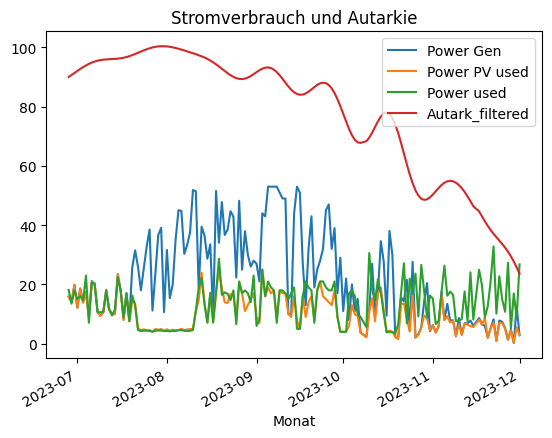

In [10]:
line_plot = actuals_with_pwr_df.plot(y=["Power Gen", "Power PV used", "Power used", 'Autark_filtered'], kind="line",
                            title='Stromverbrauch und Autarkie',
                            xlabel='Monat')
# Save the plot to a file (e.g., PNG)
fig = line_plot.get_figure()
fig.savefig(results_folder_path + 'autarkie.png', bbox_inches="tight")

get a dictionary with month start and end dates

In [11]:
def get_start_end_dates_of_month(year:int)->dict:
    """Calculates for that particular year all first days and last days of each month.
    Args:
        year (int): integer year to create the start and end dates of each month
    Returns:
        dict: a dictionary with keys for the month number and a list set of two
        dates, the start and end dates of that particular month
    """
    # date.today().year
    date_dict = {}
    for month in range(1,13):
        if month != 12:
            dict_value = []
            start_date = date(year, month, 1)
            end_date = date(year, month + 1, 1)
            end_date = end_date - timedelta(days=1)
            dict_value.append(start_date)
            dict_value.append(end_date)
            date_dict[month] = dict_value
        else:
            dict_value = []
            start_date = date(year, 12, 1)
            end_date = date(year, 12, 31)
            dict_value.append(start_date)
            dict_value.append(end_date)
            date_dict[month] = dict_value
    return date_dict

Calculate the monthy statistics(mainly based on the daily power data). The rest of the actuals file isn't tracked clearly.

In [12]:

date_dict = get_start_end_dates_of_month(ANALYSIS_YEAR)

mth_stats_diary = {}
for key, dates in date_dict.items():
    mth_df = actuals_df[dates[0]:dates[1]]
    if mth_df.empty == False:
        mth_dict = {}
        # energy production statistics
        mth_dict["Stromproduktion (kWh)"] = round(mth_df["Power Gen"].sum(), 2)
        mth_dict["Eigenverbrauch (kWh)"] = round(mth_df["Power PV used"].sum(), 2)
        mth_dict["Stromverbrauch (kWh)"] = round(mth_df["Power used"].sum(), 2)
        mth_dict["Höchste Strom-Tagesproduktion (kWh)"] = round(mth_df["Power Gen"].max(), 2)
        mth_dict["Datum der höchsten Stromproduktion:"] = mth_df["Power Gen"].idxmax()
        mth_stats_diary[dates[0].strftime('%B')] = mth_dict

# Creates DataFrame. 
mth_stats_df = pd.DataFrame(mth_stats_diary) 
  
# Print the data 
mth_stats_df = mth_stats_df.transpose()
mth_stats_df.index.name = "Jahr"
result_file = results_folder_path + str(ANALYSIS_YEAR) + "_mthstats_csv"
mth_stats_df.to_csv(result_file, header=True, index=True)

Plotting results

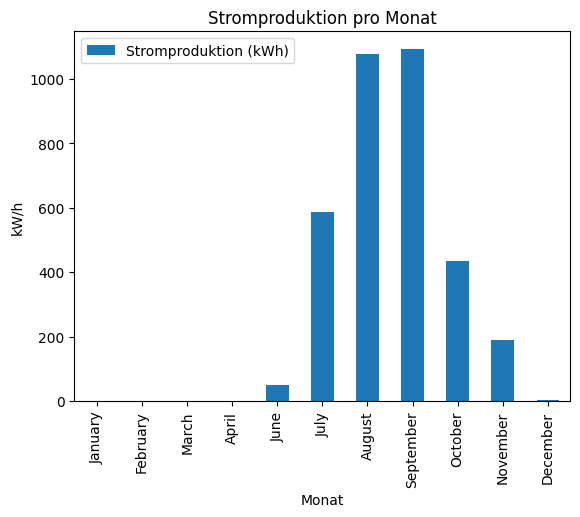

In [13]:
# power production in each month
# create the plot using a bar chart
bar_plot = mth_stats_df.plot(y='Stromproduktion (kWh)', kind="bar",
                            title='Stromproduktion pro Monat',
                            xlabel='Monat', ylabel='kW/h')
# Save the plot to a file (e.g., PNG)
fig = bar_plot.get_figure()
fig.savefig(results_folder_path + 'power_prod_per_mth.png', bbox_inches="tight")


Handling the historical data to display resource needs over years. First by loading the data to a dataframe.

In [14]:
historical_df = pd.read_csv(hist_file_name, index_col='Year')

Display the data in a bar chart

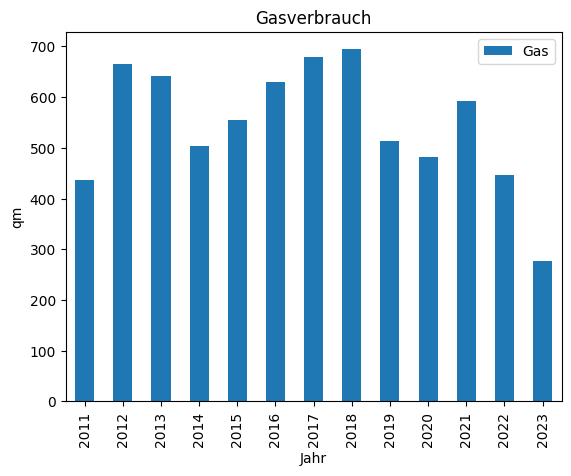

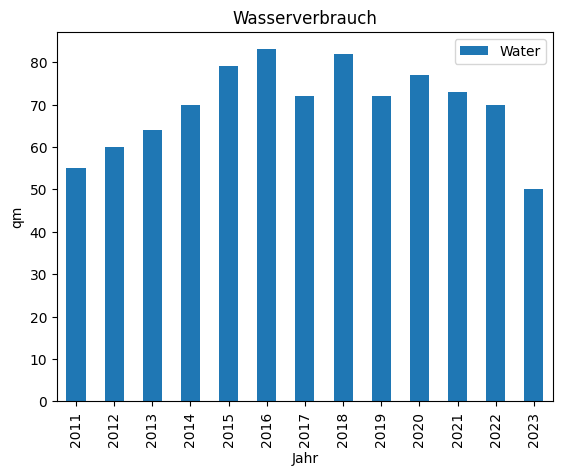

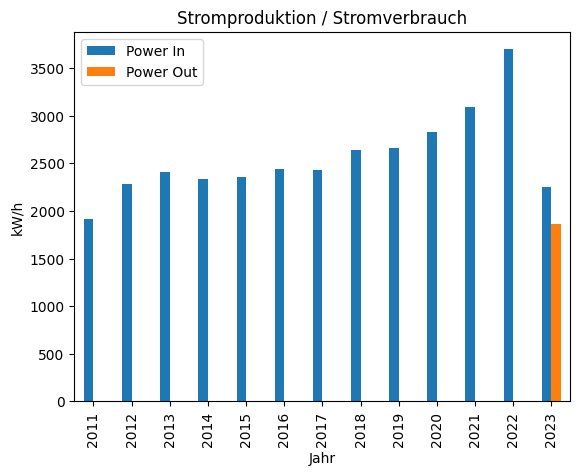

In [15]:
# gas consumption per year
# create the plot using a bar chart
bar_plot = historical_df.plot(y=["Gas"], kind="bar", title='Gasverbrauch',
                                xlabel='Jahr', ylabel='qm')
# Save the plot to a file (e.g., PNG)
fig = bar_plot.get_figure()
fig.savefig(results_folder_path + 'hist_gas_per_year.png', bbox_inches="tight")

# water consumption per year
# create the plot using a bar chart
bar_plot = historical_df.plot(y=["Water"], kind="bar", title='Wasserverbrauch',
                                xlabel='Jahr', ylabel='qm')
# Save the plot to a file (e.g., PNG)
fig = bar_plot.get_figure()
fig.savefig(results_folder_path + 'hist_water_per_year.png', bbox_inches="tight")

# power consumption/production per year
# create the plot using a bar chart
bar_plot = historical_df.plot(y=["Power In", "Power Out"], kind="bar",
                                title='Stromproduktion / Stromverbrauch',
                                xlabel='Jahr', ylabel='kW/h')
# Save the plot to a file (e.g., PNG)
fig = bar_plot.get_figure()
fig.savefig(results_folder_path + 'hist_power_per_year.png', bbox_inches="tight")
